# Group 4 Project 2

In [1]:
import pandas as pd
import requests
from dotenv import load_dotenv
import os
import json
import time

### API call for entire NY state  

Data for Counties:  
103 Suffolk (LI),  
005 Bronx,  
061 NYC,  
081 Queens  
085 Richmond  

Parameter Codes used:

42101 - Carbon monoxide (has data in four counties)  
44201 - Ozone (has data in all above five counties)  
88101 - PM2.5 (has data in all above five counties)  

81102 - PM10 (Bronx 117, Queens 58)  
42401 - Sulfer Dioxide (Bronx 3649, Queens 1822)  
42602 - Nitrogen Dioxide (Queens 1454, Bronx 1450, Suffolk 730)  

# Data Extract using API calls
Get Daily Summary Data by State  
API Source for Daily AQI data from EPA - https://aqs.epa.gov/aqsweb/documents/data_api.html#daily   

In [2]:
# Set environment variables from the .env in the local environment
load_dotenv()
epa_api_key = os.getenv("EPA_API_KEY")
email = os.getenv("EMAIL")
type(epa_api_key)

str

In [3]:
# Build URL
state = "36"  # New York State code
# API url
url = "https://aqs.epa.gov/data/api/dailyData/byState?"
# Years list
years_list = list(range(2013, 2025))

# List of parameter codes
parameter_codes = [42101, 44201, 88101] #, 88101, 81102, 42401, 42602]  

# List of counties
county_list = ['005','047','059','061','081','085','103']

In [4]:
# Pick specific columns from larger dataset
selected_columns = ['county_code', 'parameter_code', 'latitude', 'longitude', 'sample_duration_code', 
                    'pollutant_standard','date_local','units_of_measure', 'observation_count', 
                    'validity_indicator', 'arithmetic_mean','first_max_value','first_max_hour', 'aqi', 'county', 'city']

In [5]:
# Function to make API call and return selected columns as DataFrame
def get_data_for_parameter(parameter_code):
    # Build URL
    query_url = (f"{url}email={email}&key={epa_api_key}&param={parameter_code}&bdate={begin_date}&edate={end_date}"
               + f"&state={state}" )

    # API Call to get data for just one Parameter & for one year
    param_data = requests.get(query_url).json()
    #Add 2 second wait step
    time.sleep(2)
    #param_data.raise_for_status()  # Raise an error for bad status codes
    json.dumps(param_data, indent=4)
    # Convert data into DataFrame
    param_df = pd.json_normalize(param_data["Data"])
    # Sort by Dates
    param_df.sort_values(by='date_local',inplace=True)

    
    # Dataframe for only five counties
    # five_counties_param_df = param_df[param_df['county_code'].isin(five_counties)]
    five_counties_param_df = param_df.loc[param_df['county_code'].isin(county_list)]

    # Return data frame that has only selected columns
    five_counties_param_df = five_counties_param_df[selected_columns]

    print(begin_date, end_date, parameter_code)
    print(five_counties_param_df['county_code'].value_counts())

    return five_counties_param_df

In [6]:
# Loop for years list (2013 - 2024)
for yrs_index, year in enumerate (years_list):
    
    #Build begin date and end date values
    begin_date = str(year) + "0101"
    end_date = str(year) + "1231"
    
    # Loop through the parameter codes, get data, and merge
    for param_index, code in enumerate (parameter_codes):

        # Call function to get data using API
        all_counties_param_df = get_data_for_parameter(code)  
        all_counties_param_df = all_counties_param_df.dropna()
        all_counties_param_df.sort_index(ascending=True, inplace=True)
        
        # Use groupby and agg function to get one record per day when multiple rows of data exist for "same day & for same type of test"
        counties_aggr_param_df = all_counties_param_df.groupby(['county_code','date_local']).agg({
                                   'parameter_code': 'first', 
                                   'latitude': 'first',
                                   'longitude': 'first',
                                   'sample_duration_code': 'first',
                                   'pollutant_standard': 'first',
                                   'units_of_measure': 'first',
                                   'observation_count': 'sum',
                                   'validity_indicator': 'first',
                                   'arithmetic_mean': 'mean',
                                   'first_max_value': 'mean',
                                   'first_max_hour': 'mean',
                                   'aqi': 'mean',
                                   'county': 'first',
                                   'city': 'first' })

        # Dataframe for all parameters & for all specified counties
        if param_index == 0:
            counties_param_joined_df = counties_aggr_param_df 
        else:
            counties_param_joined_df = counties_param_joined_df.join(counties_aggr_param_df, how="outer",rsuffix=code)

    # Dataframe for All years & parameters
    if yrs_index == 0:          
        all_yrs_counties_params_df = counties_param_joined_df
    else:   
        all_yrs_counties_params_df = pd.concat([all_yrs_counties_params_df, counties_param_joined_df], axis='rows', join="outer")

# Sort ascending
all_yrs_counties_params_df.sort_index(ascending=True, inplace=True)

all_yrs_counties_params_df.head()

20130101 20131231 42101
county_code
081    724
005    722
061    712
Name: count, dtype: int64
20130101 20131231 44201
county_code
103    3861
005    2904
061    1452
081    1440
085    1263
Name: count, dtype: int64
20130101 20131231 88101
county_code
061    3568
081    2664
005    1936
103     936
047     912
085     832
Name: count, dtype: int64
20140101 20141231 42101
county_code
081    728
005    712
061    706
Name: count, dtype: int64
20140101 20141231 44201
county_code
103    3963
005    2910
081    1438
061    1379
085    1022
Name: count, dtype: int64
20140101 20141231 88101
county_code
081    5793
005    4605
061    3584
103     912
047     888
085     824
Name: count, dtype: int64
20150101 20151231 42101
county_code
081    730
005    730
061    712
Name: count, dtype: int64
20150101 20151231 44201
county_code
103    3672
005    2920
081    1459
061    1453
085    1012
Name: count, dtype: int64
20150101 20151231 88101
county_code
081    6029
005    5165
061    3712
085     9

parameter_code  latitude  longitude  \
county_code date_local                                       
005         2013-01-01          42101   40.8679  -73.87809   
            2013-01-02          42101   40.8679  -73.87809   
            2013-01-03          42101   40.8679  -73.87809   
            2013-01-04          42101   40.8679  -73.87809   
            2013-01-05          42101   40.8679  -73.87809   

                       sample_duration_code pollutant_standard  \
county_code date_local                                           
005         2013-01-01                    Z     CO 8-hour 1971   
            2013-01-02                    Z     CO 8-hour 1971   
            2013-01-03                    Z     CO 8-hour 1971   
            2013-01-04                    Z     CO 8-hour 1971   
            2013-01-05                    Z     CO 8-hour 1971   

                         units_of_measure  observation_count  \
county_code date_local                                         
005         2013-01-01  Parts per million               19.0   
            2013-01-02  Parts per million               24.0   
            2013-01-03  Parts per million               24.0   
            2013-01-04  Parts per million               24.0   
            2013-01-05  Parts per million               24.0   

                       validity_indicator  arithmetic_mean  first_max_value  \
county_code date_local                                                        
005         2013-01-01                  Y         0.547368              0.6   
            2013-01-02                  Y         0.416667              0.5   
            2013-01-03                  Y         0.495833              0.6   
            2013-01-04                  Y         0.575000              0.6   
            2013-01-05                  Y         0.633333              0.8   

                        ...  pollutant_standard88101  \
county_code date_local  ...                            
005         2013-01-01  ...        PM25 24-hour 2006   
            2013-01-02  ...                      NaN   
            2013-01-03  ...                      NaN   
            2013-01-04  ...        PM25 24-hour 2006   
            2013-01-05  ...                      NaN   

                              units_of_measure88101 observation_count88101  \
county_code date_local                                                       
005         2013-01-01  Micrograms/cubic meter (LC)                   16.0   
            2013-01-02                          NaN                    NaN   
            2013-01-03                          NaN                    NaN   
            2013-01-04  Micrograms/cubic meter (LC)                   16.0   
            2013-01-05                          NaN                    NaN   

                       validity_indicator88101 arithmetic_mean88101  \
county_code date_local                                                
005         2013-01-01                       Y                  9.9   
            2013-01-02                     NaN                  NaN   
            2013-01-03                     NaN                  NaN   
            2013-01-04                       Y                 16.5   
            2013-01-05                     NaN                  NaN   

                        first_max_value88101  first_max_hour88101 aqi88101  \
county_code date_local                                                       
005         2013-01-01                   9.9                  0.0     52.0   
            2013-01-02                   NaN                  NaN      NaN   
            2013-01-03                   NaN                  NaN      NaN   
            2013-01-04                  16.5                  0.0     64.5   
            2013-01-05                   NaN                  NaN      NaN   

                       county88101 city88101  
county_code date_local                        
005         2013-01-01       Bronx  New Yor

In [8]:
all_yrs_counties_params_df.tail(3)

parameter_code  latitude  longitude  \
county_code date_local                                       
103         2024-03-29            NaN       NaN        NaN   
            2024-03-30            NaN       NaN        NaN   
            2024-03-31            NaN       NaN        NaN   

                       sample_duration_code pollutant_standard  \
county_code date_local                                           
103         2024-03-29                  NaN                NaN   
            2024-03-30                  NaN                NaN   
            2024-03-31                  NaN                NaN   

                       units_of_measure  observation_count validity_indicator  \
county_code date_local                                                          
103         2024-03-29              NaN                NaN                NaN   
            2024-03-30              NaN                NaN                NaN   
            2024-03-31              NaN                NaN                NaN   

                        arithmetic_mean  first_max_value  ...  \
county_code date_local                                    ...   
103         2024-03-29              NaN              NaN  ...   
            2024-03-30              NaN              NaN  ...   
            2024-03-31              NaN              NaN  ...   

                        pollutant_standard88101        units_of_measure88101  \
county_code date_local                                                         
103         2024-03-29                      NaN                          NaN   
            2024-03-30                      NaN                          NaN   
            2024-03-31        PM25 24-hour 2006  Micrograms/cubic meter (LC)   

                       observation_count88101 validity_indicator88101  \
county_code date_local                                                  
103         2024-03-29                    NaN                     NaN   
            2024-03-30                    NaN                     NaN   
            2024-03-31                    8.0                       Y   

                       arithmetic_mean88101  first_max_value88101  \
county_code date_local                                              
103         2024-03-29                  NaN                   NaN   
            2024-03-30                  NaN                   NaN   
            2024-03-31                  4.4                   4.4   

                        first_max_hour88101 aqi88101 county88101  \
county_code date_local                                             
103         2024-03-29                  NaN      NaN         NaN   
            2024-03-30                  NaN      NaN         NaN   
            2024-03-31                  0.0     24.0     Suffolk   

                               city88101  
county_code date_local                    
103         2024-03-29               NaN  
            2024-03-30               NaN  
            2024-03-31  East Farmingdale  

[3 rows x 42 columns]

In [9]:
# Reset Index
all_yrs_counties_params_df.reset_index(inplace=True)

In [10]:
all_yrs_counties_params_df.shape

(21020, 44)

In [11]:
# Add new column for Max AQI value
all_yrs_counties_params_df['aqi_max'] = all_yrs_counties_params_df[['aqi', 'aqi44201', 'aqi88101']].max(axis=1)

In [12]:
all_yrs_counties_params_df.columns

Index(['county_code', 'date_local', 'parameter_code', 'latitude', 'longitude',
       'sample_duration_code', 'pollutant_standard', 'units_of_measure',
       'observation_count', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'county', 'city',
       'parameter_code44201', 'latitude44201', 'longitude44201',
       'sample_duration_code44201', 'pollutant_standard44201',
       'units_of_measure44201', 'observation_count44201',
       'validity_indicator44201', 'arithmetic_mean44201',
       'first_max_value44201', 'first_max_hour44201', 'aqi44201',
       'county44201', 'city44201', 'parameter_code88101', 'latitude88101',
       'longitude88101', 'sample_duration_code88101',
       'pollutant_standard88101', 'units_of_measure88101',
       'observation_count88101', 'validity_indicator88101',
       'arithmetic_mean88101', 'first_max_value88101', 'first_max_hour88101',
       'aqi88101', 'county88101', 'city88101', 'aqi_max'],
      dtype='ob

In [13]:
# Verify new column aqi_max values in few records
aqi_values = all_yrs_counties_params_df[['county_code', 'date_local', 'aqi', 'aqi44201', 'aqi88101', 'aqi_max']][1:10]
aqi_values

,county_code,date_local,aqi,aqi44201,aqi88101,aqi_max
1,005,2013-01-02,6.0,20.5,NaN,20.5
2,005,2013-01-03,7.0,19.0,NaN,19.0
3,005,2013-01-04,7.0,19.0,64.5,64.5
4,005,2013-01-05,9.0,25.0,NaN,25.0
5,005,2013-01-06,9.0,18.0,NaN,18.0
6,005,2013-01-07,9.0,23.5,57.0,57.0
7,005,2013-01-08,10.0,9.5,NaN,10.0
8,005,2013-01-09,15.0,17.5,NaN,17.5
9,005,2013-01-10,5.0,21.5,35.5,35.5


In [14]:
# Dataframe dimensions
all_yrs_counties_params_df.shape

(21020, 45)

In [15]:
# List total records by county
print(all_yrs_counties_params_df['county_code'].value_counts())

county_code
005    4109
081    4109
061    4098
103    4064
085    3190
047    1450
Name: count, dtype: int64


In [16]:
# This does not give us true count since columns appears multiple times with different suffixes (based on param value)
# when a field is blank in one column then other columns related columns in data frame might have some value in the same row
all_yrs_counties_params_df.isnull().sum()

county_code                     0
date_local                      0
parameter_code               7842
latitude                     7842
longitude                    7842
sample_duration_code         7842
pollutant_standard           7842
units_of_measure             7842
observation_count            7842
validity_indicator           7842
arithmetic_mean              7842
first_max_value              7842
first_max_hour               7842
aqi                          7842
county                       7842
city                         7842
parameter_code44201          2003
latitude44201                2003
longitude44201               2003
sample_duration_code44201    2003
pollutant_standard44201      2003
units_of_measure44201        2003
observation_count44201       2003
validity_indicator44201      2003
arithmetic_mean44201         2003
first_max_value44201         2003
first_max_hour44201          2003
aqi44201                     2003
county44201                  2003
city44201     

In [161]:
# Write output file to /Resources folder
all_yrs_counties_params_df.to_csv("Resources/selected_counties_features_42101_44201_88101_aqi_data_2013_to_2024.csv", index=False)

# Time Series Analysis with Prophet

In [3]:
# Install the required libraries
!pip install prophet

In [109]:
pip install matplotlib basemap basemap-data-hires

     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ---------------------------------------- 56.0/56.0 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/507.1 kB ? eta -:--:--
   -------------------- ------------------- 256.0/507.1 kB 7.9 MB/s eta 0:00:01
   ---------------------------------------  501.8/507.1 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 507.1/507.1 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/91.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/91.1 MB 5.7 MB/s eta 0:00:17
   ---------------------------------------- 0.5/91.1 MB 5.2 MB/s eta 0:00:18
   ---------------------------------------- 0.8/91.1 MB 5.7 MB/s eta 0:00:16
   ---------------------------------------- 1.1/91.1 MB 6.5 MB/s eta 0:00:14
    --------------------------------------- 1.5/91.1 MB 6.6 MB/s eta 0:00:14
    --------------------------------------- 1.7/91.1 MB 6.4 MB/s eta 0:00:14
    -

In [110]:
# Import the required libraries and dependencies
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [111]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

new_df = pd.read_csv(
    "Resources/selected_counties_features_42101_44201_88101_aqi_data_2013_to_2024.csv",
    index_col='date_local',
    low_memory=False,
    parse_dates=True)

#Isolate future_new_df to two columns for Prophet model
future_new_df = new_df[["aqi_max"]] 

# Review the first and last five rows of the DataFrame
display(future_new_df.head())
display(future_new_df.tail())

,aqi_max
date_local,
2013-01-01,52.0
2013-01-02,20.5
2013-01-03,19.0
2013-01-04,64.5
2013-01-05,25.0


,aqi_max
date_local,
2024-03-27,26.444444
2024-03-28,33.000000
2024-03-29,44.333333
2024-03-30,43.000000
2024-03-31,44.333333


In [11]:
# Reset the index so that we recode the columns for Prophet
future_new_df = future_new_df.reset_index()
future_new_df.head()

,date_local,aqi_max
0,2013-01-01,52.0
1,2013-01-02,20.5
2,2013-01-03,19.0
3,2013-01-04,64.5
4,2013-01-05,25.0


In [12]:
# Label the columns ds and y so that the syntax is recognized by Prophet
future_new_df.columns = ['ds', 'y']
future_new_df.head()

,ds,y
0,2013-01-01,52.0
1,2013-01-02,20.5
2,2013-01-03,19.0
3,2013-01-04,64.5
4,2013-01-05,25.0


In [90]:
# Call the Prophet function, store as an object
m = Prophet(yearly_seasonality=True,  
            weekly_seasonality=False,
            daily_seasonality=False,
            
    )

m

In [91]:
# Fit the Prophet model to our dataframe
m.fit(future_new_df)

16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:00 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 10 years
future = m.make_future_dataframe(periods=5, freq='Y')

# View the first and last ten rows of the predictions
display(future.head(10))
display(future.tail(10))

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
5,2013-01-06
6,2013-01-07
7,2013-01-08
8,2013-01-09
9,2013-01-10


,ds
4104,2024-03-28
4105,2024-03-29
4106,2024-03-30
4107,2024-03-31
4108,2024-04-01
4109,2024-12-31
4110,2025-12-31
4111,2026-12-31
4112,2027-12-31
4113,2028-12-31


In [93]:
# Make a forecast based on the future DataFrame
forecast = m.predict(future)

# Review the first five rows of the forecast DataFrame
display(forecast.head())
display(forecast.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,38.768970,12.909271,53.645165,38.768970,38.768970,-4.726317,-4.726317,-4.726317,-4.726317,-4.726317,-4.726317,0.0,0.0,0.0,34.042653
1,2013-01-02,38.770882,12.366716,53.728236,38.770882,38.770882,-4.838014,-4.838014,-4.838014,-4.838014,-4.838014,-4.838014,0.0,0.0,0.0,33.932869
2,2013-01-03,38.772795,14.235061,53.808055,38.772795,38.772795,-4.942138,-4.942138,-4.942138,-4.942138,-4.942138,-4.942138,0.0,0.0,0.0,33.830657
3,2013-01-04,38.774707,12.100039,55.662199,38.774707,38.774707,-5.035170,-5.035170,-5.035170,-5.035170,-5.035170,-5.035170,0.0,0.0,0.0,33.739537
4,2013-01-05,38.776620,13.650542,53.378106,38.776620,38.776620,-5.113930,-5.113930,-5.113930,-5.113930,-5.113930,-5.113930,0.0,0.0,0.0,33.662690


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4109,2024-12-31,41.196656,16.171811,55.251679,40.968701,41.411719,-4.610827,-4.610827,-4.610827,-4.610827,-4.610827,-4.610827,0.0,0.0,0.0,36.585829
4110,2025-12-31,41.258787,15.920663,57.980641,40.517324,41.974000,-4.581821,-4.581821,-4.581821,-4.581821,-4.581821,-4.581821,0.0,0.0,0.0,36.676966
4111,2026-12-31,41.320919,15.836903,56.916271,39.882440,42.735412,-4.552887,-4.552887,-4.552887,-4.552887,-4.552887,-4.552887,0.0,0.0,0.0,36.768032
4112,2027-12-31,41.383051,17.212600,57.925706,39.206568,43.702635,-4.524087,-4.524087,-4.524087,-4.524087,-4.524087,-4.524087,0.0,0.0,0.0,36.858964
4113,2028-12-31,41.445353,16.353417,58.587402,38.415494,44.598292,-4.610827,-4.610827,-4.610827,-4.610827,-4.610827,-4.610827,0.0,0.0,0.0,36.834526


C:\Users\Chearine\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Chearine\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


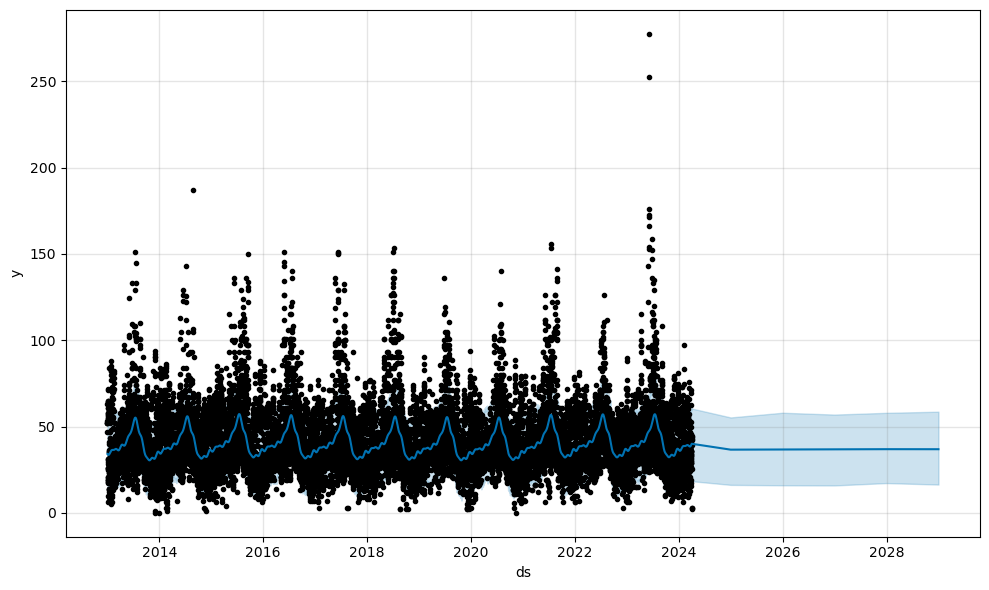

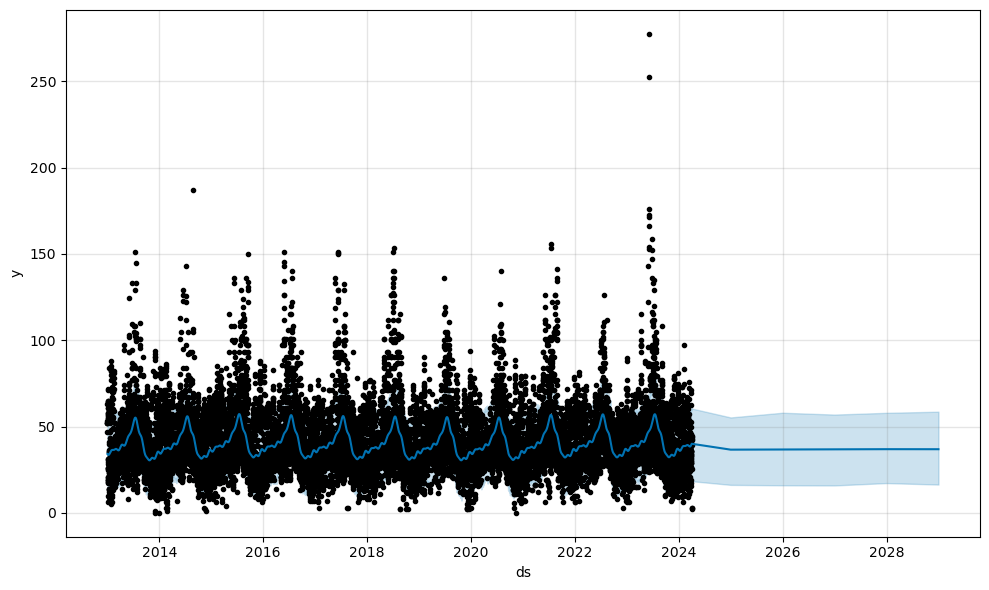

In [94]:
# Plot the Prophet predictions for the next ten years of AQI
m.plot(forecast)

C:\Users\Chearine\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Chearine\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Chearine\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

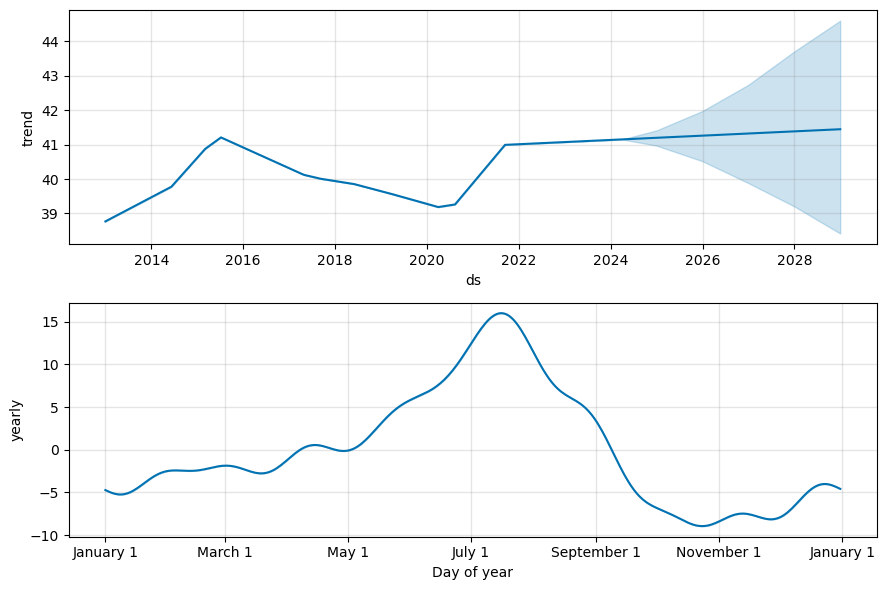

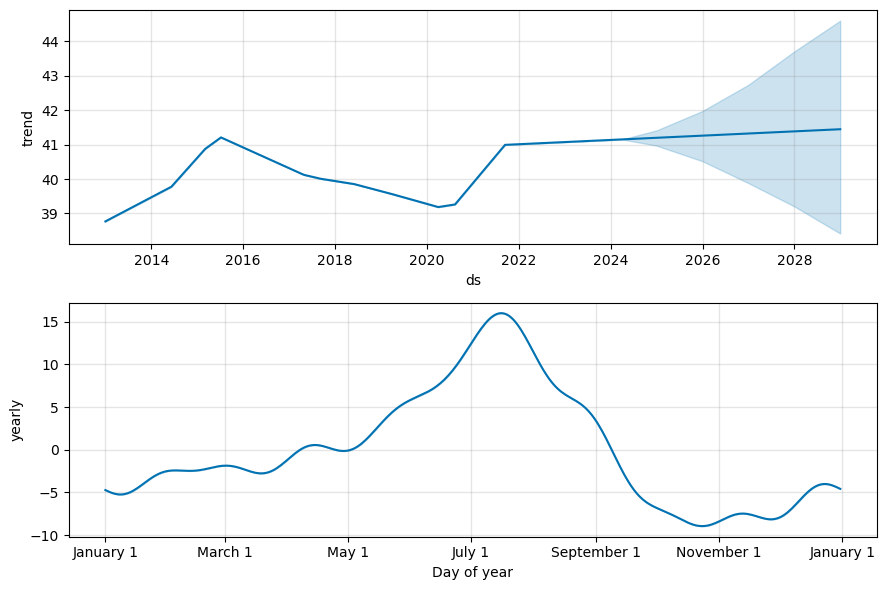

In [131]:
m.plot_components(forecast)

# Plotting to see trends and relationships with matplotlib

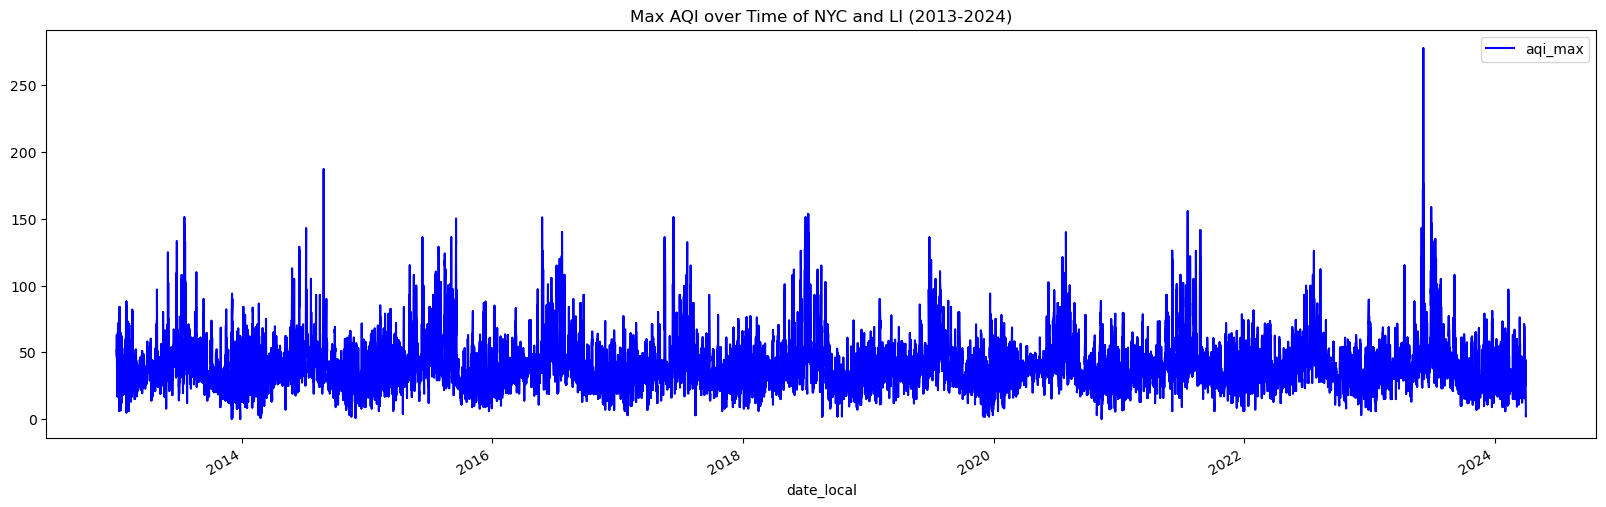

In [105]:
# Plotting max AQI over time
new_df.plot( y = 'aqi_max', color = ['blue'], title = 'Max AQI over Time of NYC and LI (2013-2024)')
plt.gcf().set_size_inches(20, 6)
plt.show()

## AQI (Air Quality Index) shown on a map

In [128]:
#Prepare data frame for map plotting
grouped_df = new_df.groupby('county')[['aqi_max','latitude','longitude']].mean().reset_index()
new_map_df = grouped_df.dropna()
new_map_df

,county,aqi_max,latitude,longitude
0,Bronx,41.949989,40.867900,-73.878090
1,New York,36.158158,40.819760,-73.948250
2,Queens,43.751219,40.736913,-73.820581
3,Suffolk,40.169433,40.961017,-73.139046


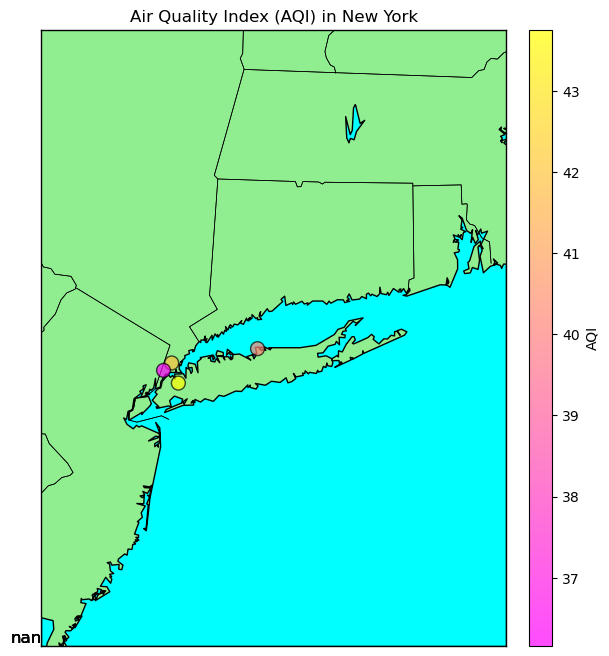

In [130]:
# Create a map centered on New York City region showing mean AQI for 2013-2023

fig, ax = plt.subplots(figsize=(10, 8))


map = Basemap(projection='merc', llcrnrlat=39, urcrnrlat=43,
                llcrnrlon=-75, urcrnrlon=-71, lat_ts=41, resolution='i')

# Draw map details
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='lightgreen', lake_color='aqua')

# Convert latitude and longitude to map projection coordinates for New York
x, y = map(new_map_df['longitude'].values, new_map_df['latitude'].values)

# Plot AQI values with a scatter plot
sc = map.scatter(x, y, c=new_map_df['aqi_max'], s=100, cmap='spring', alpha=0.7, edgecolors='k', zorder=2)

# Add a colorbar
cbar = map.colorbar(sc, location='right', pad='5%')
cbar.set_label('AQI')

# Add city labels
for county, lon, lat in zip(new_map_df['county'], new_map_df['longitude'], new_map_df['latitude']):
    plt.text(lon, lat, city, fontsize=12, ha='right', va='bottom', transform=ax.transData)

plt.title('Air Quality Index (AQI) in New York')
plt.show()

# Machine Learning Models for 88101 (PM2.5)